In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import matplotlib.lines as lines
import seaborn as sns
from tqdm import tqdm
import pickle
%matplotlib inline

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

from src.smallworld import grouped_scale_free_graph

# Load / Generate Network Data

In [2]:
# Hyperparameter limits
n = 500                  # number of genes
pmin, pmax = 2, n//5     # limits on expected degree
imin, imax = 1, 1000     #         - delta_in
omin, omax = 1, 1000     #         - delta_out
kmin, kmax = 1, n//5     #         - number of groups
wmin, wmax = 1, 1000     #         - modularity term


# Load or Generate
stem = 'figdata/fig2.gsfg.v2.'
if os.path.exists(stem + 'stats.pkl') and os.path.exists(stem + 'graphs.pkl'):
    with open(stem + 'stats.pkl','rb') as i:
        stats=pickle.load(i)
    with open(stem + 'graphs.pkl','rb') as i:
        graphs=pickle.load(i) 
else:
    graphs = {x:[] for x in 'Gpiokw'}
    stats = {x:[] for x in ['|E|','pow_in','pow_out','M','n_reg','n_hub','in_frac']}
    for _ in tqdm(range(500)):
        # generate graph parameters
        p = np.random.choice(np.arange(pmin, pmax))
        i = np.random.choice(np.arange(imin, imax))
        o = np.random.choice(np.arange(omin, omax))
        k = np.random.choice(np.arange(kmin, kmax))
        u = np.random.random()
        w = np.clip((k-1)*u/(1-u), wmin, wmax)
        # graph
        G = grouped_scale_free_graph(n=500, alpha=1e-100, beta=1 - 1./p, gamma=1./p,
                                     delta_in=i, delta_out=o, k=k, kappa=w, 
                                     create_using=nx.DiGraph())
        # store graph and parameters
        for s,x in zip('piokw', [p,i,o,k,w]):
            graphs[s].append(x)
        # compute and store summary statistics
        outs=np.array([o for _,o in G.out_degree(G.nodes(), None)])
        ins =np.array([i for _,i in G.in_degree(G.nodes(), None)])
        groups=nx.get_node_attributes(G,'group')
        sets=[{i for i in range(n) if groups[i]==g} for g in range(k)]

        stats['|E|'].append(     G.number_of_edges() )
        stats['pow_in'].append(  np.var(ins) )
        stats['pow_out'].append( np.var(outs) )
        stats['M'].append(       nx.algorithms.community.modularity(G, sets) )
        # todo: add fraction of edges within-group
        stats['in_frac'].append(sum(G.subgraph(s).number_of_edges() for s in sets) / G.number_of_edges())
        stats['n_reg'].append(   sum(outs > 0) )
        stats['n_hub'].append(   sum(outs > 9) )
        
    with open(stem + 'stats.pkl','wb') as o:
        pickle.dump(stats, o)
    with open(stem + 'graphs.pkl','wb') as o:
        pickle.dump(graphs, o)


# Convenience Arrays
p=np.array(graphs['p'])
delta_in=np.array(graphs['i'])
delta_out=np.array(graphs['o'])
k=np.array(graphs['k'])
w=np.array(graphs['w'])

modE=np.array(stats['|E|'])
vari=np.array(stats['pow_in'])
varo=np.array(stats['pow_out'])
modl=np.array(stats['M'])
nreg=np.array(stats['n_reg'])
nhub=np.array(stats['n_hub'])

maxo=max(n*np.sqrt(varo)/modE)
maxi=max(n*np.sqrt(vari)/modE)

# Figure 2

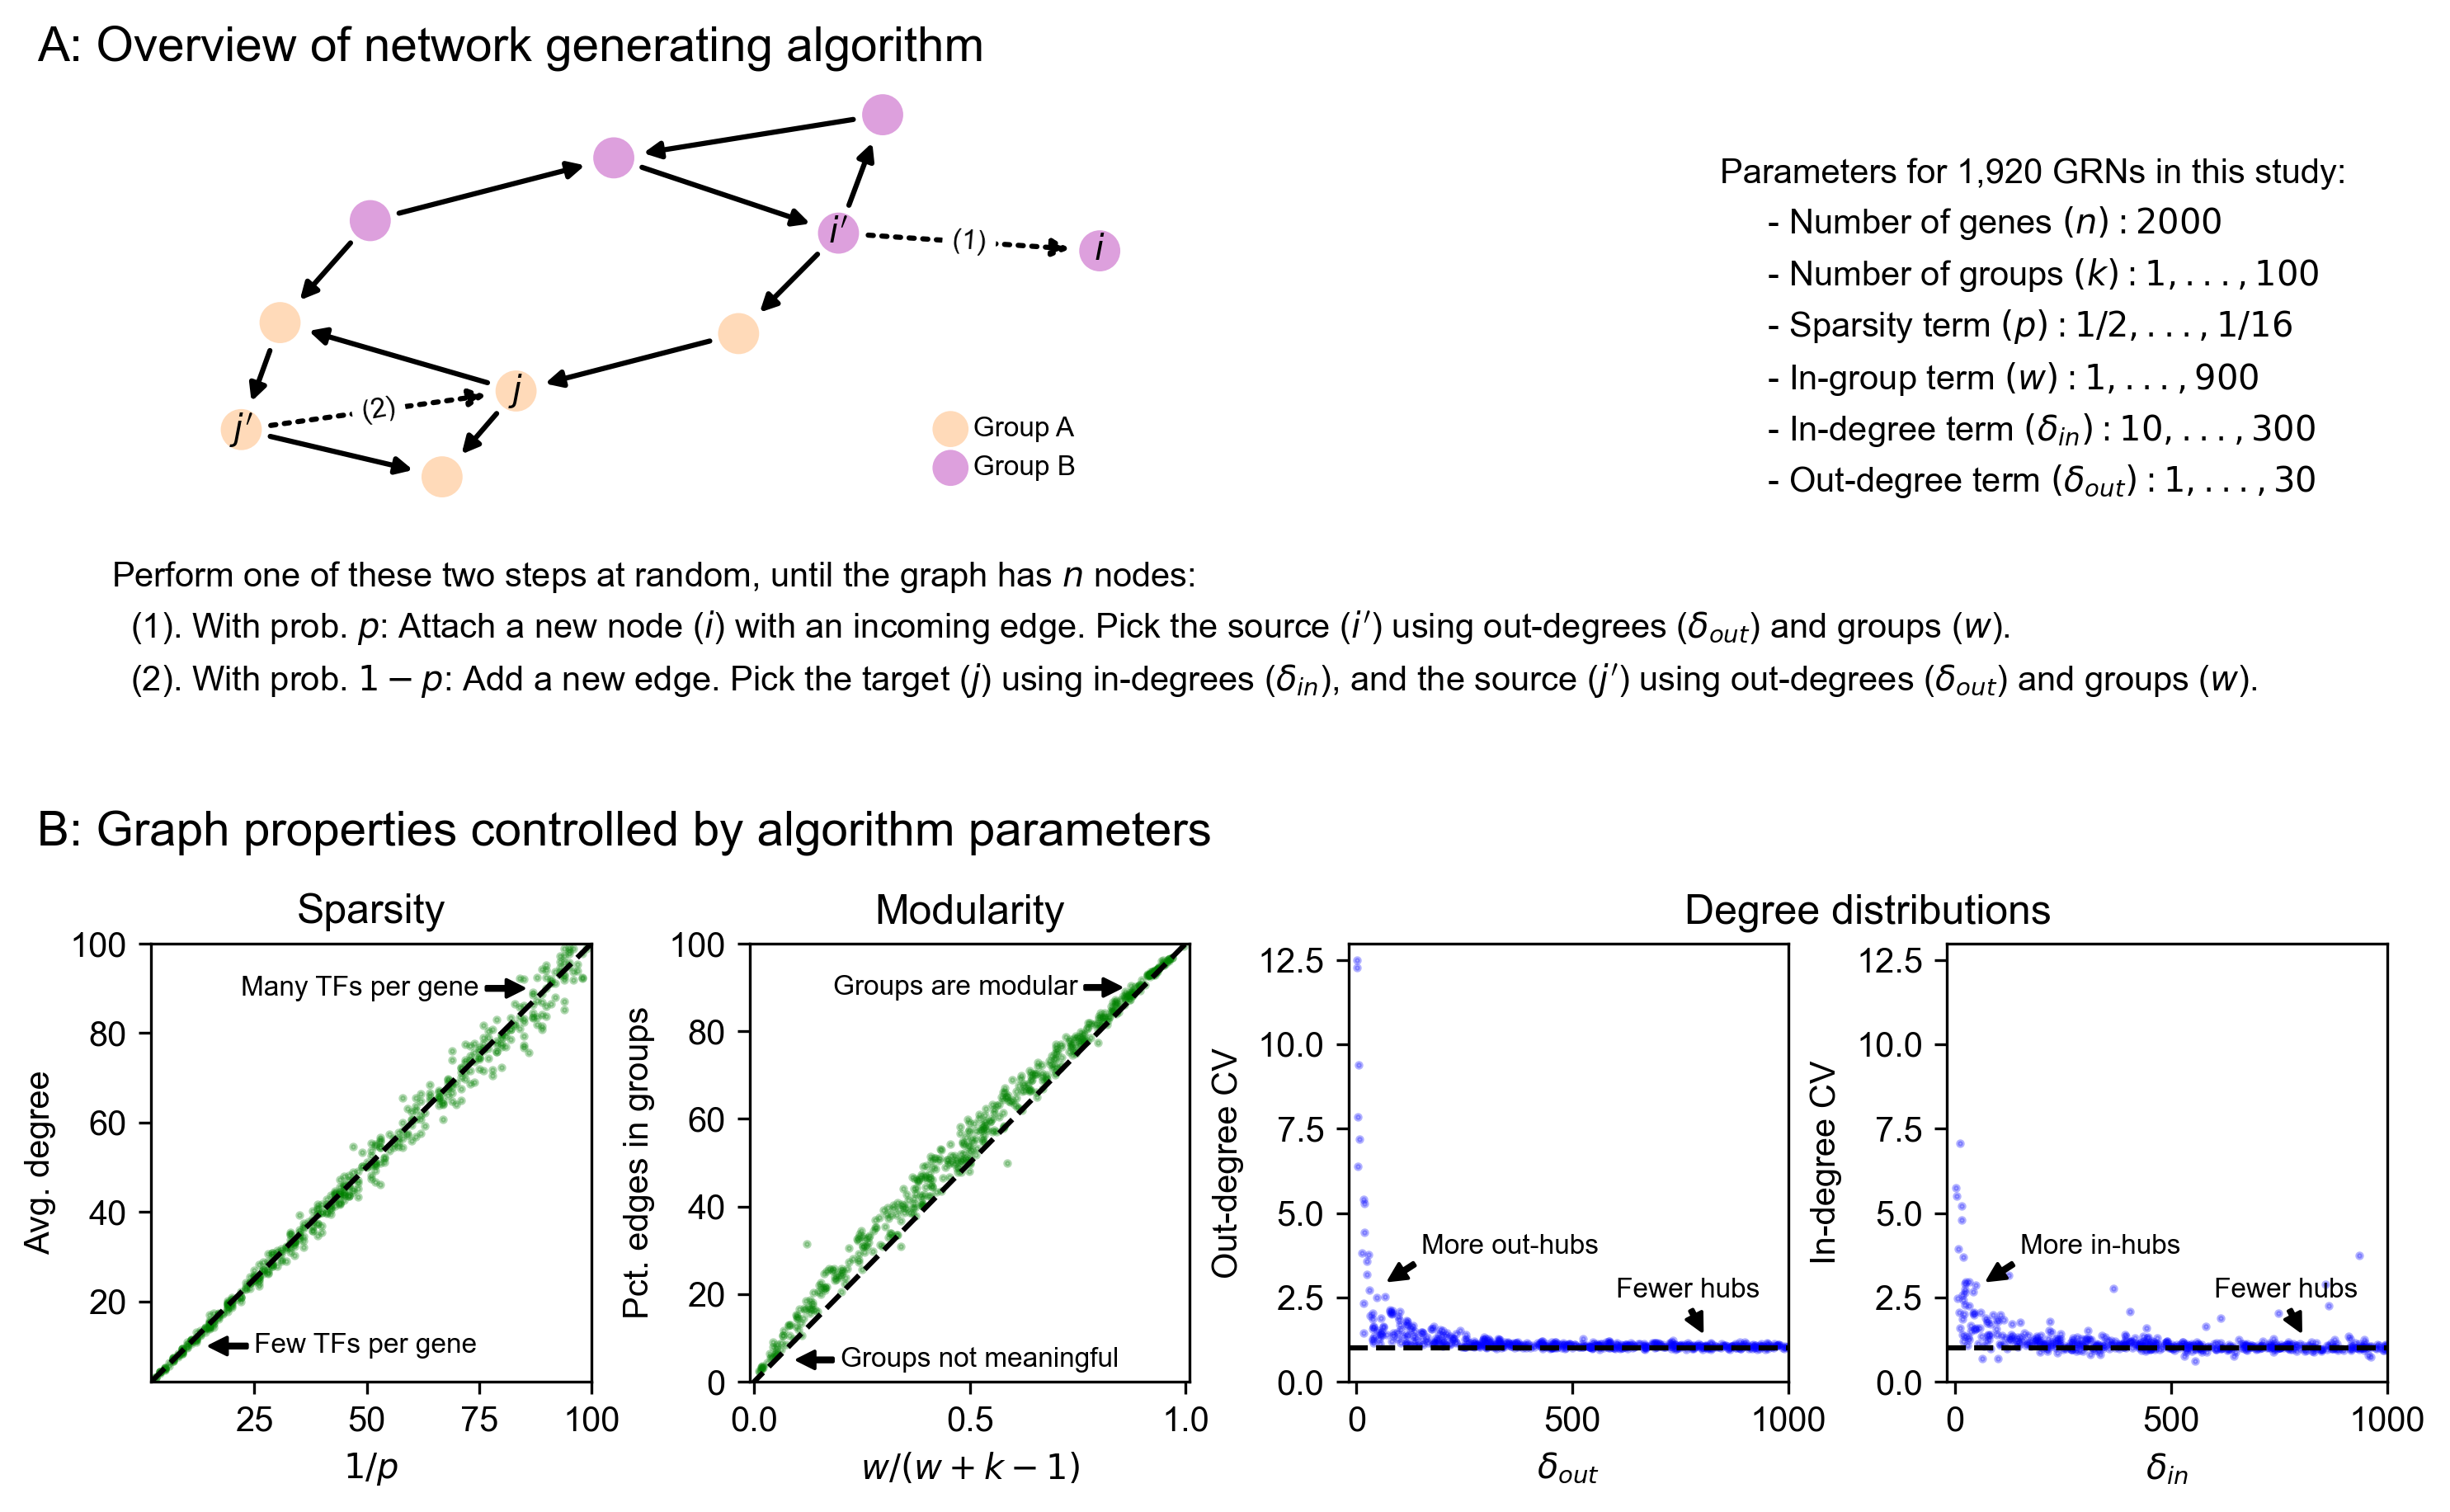

In [3]:
# Figure setup
fig = plt.figure(figsize=(10,6), dpi=300)
grid = gs.GridSpec(2, 4, figure=fig)

# Leave space for other graphical elements
#ax = fig.add_subplot(grid[0,:]);

ax = fig.add_subplot(grid[:1,0:2])
G = nx.stochastic_block_model([5,5], p=[[0.3,0.03],[0.03,0.3]], 
                              nodelist = None, seed=2012,
                              directed=True, selfloops=False, sparse=False)
pos = nx.kamada_kawai_layout(G)
G.remove_edge(7,6); G.add_edge(6,7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_shape='o', node_size=120, node_color=[['peachpuff','plum'][i >= len(G)/2] for i in G.nodes])
nx.draw_networkx_labels(G, pos, ax=ax, labels=dict(enumerate([r'$j$','','',r"$j'$",'','',r"$i'$",r'$i$','',''])), font_size=10)
dashes=[(3,0), (6,7)]
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[e for e in G.edges if e not in dashes], width=1.5, edge_color='k', style='-')
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=dashes, width=1.5, edge_color='k', style=':')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(3,0):'(2)', (6,7):'(1)'}, font_size=8)

nx.draw_networkx_nodes(nx.Graph([(10,11)]), {10:np.array([-0.7, 0.7]), 11:np.array([-0.7, 0.9])}, ax=ax, 
                       node_shape='o', node_size=90, node_color=['peachpuff', 'plum'])
nx.draw_networkx_labels(nx.Graph([(10,11)]), {10:np.array([-0.7, 0.7]), 11:np.array([-0.7, 0.9])}, ax=ax, 
                        labels={10:'   Group A', 11:'   Group B'}, font_size=8, horizontalalignment='left')

ax.invert_yaxis(); 
ax.invert_xaxis();
ax.axis('off');

# Parameters under control by generating algorithm
fig.text(0.02, 0.45, 'B: Graph properties controlled by algorithm parameters', 
         fontsize=14, fontweight='bold', verticalalignment='bottom', horizontalalignment='left');
 
# Sparsity
ax = fig.add_subplot(grid[-1,0]);

ax.plot(p, modE/n, 'g.', ms=3, alpha=0.3)
ax.plot([pmin, pmax], [pmin, pmax], 'k--')
ax.set_xlim(pmin,pmax); 
ax.set_ylim(pmin,pmax);
ax.set_xlabel(r'$1/p$'); 
ax.set_ylabel('Avg. degree');
ax.set_title('Sparsity');
ax.annotate('Few TFs per gene', xy=(15, 10), xytext=(25, 10), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );
ax.annotate('Many TFs per gene', xy=(85, 90), xytext=(75, 90), 
            fontsize=8, ha='right', va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );


# Modularity (Fract. edges within)
ax = fig.add_subplot(grid[-1,1]);
ax.plot((w/(w+k-1))[k>1], 100*np.array(stats['in_frac'])[k>1], 'g.', ms=3, alpha=0.3)
ax.plot([-0.01,1.01],[-1,101],'k--')

ax.set_xlim(-0.01,1.01);
ax.set_ylim(0, 100); 
ax.set_ylabel('Pct. edges in groups');
ax.annotate('Groups not meaningful', xy=(.1, 5), xytext=(.2, 5), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );
ax.annotate('Groups are modular', xy=(.85, 90), xytext=(.75, 90), 
            fontsize=8, ha='right', va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax.set_xlabel(r'$w/(w+k-1)$'); 
ax.set_title('Modularity');



# Degree distribution (out)
ax = fig.add_subplot(grid[-1,2]);
ax.plot(delta_out, n*np.sqrt(varo)/modE, 'b.', ms=3, alpha=0.3)
ax.plot([omin-20,omax],[1,1],'k--',linewidth=1.5)

#ax.set_yscale('log');
ax.set_xlim(omin-20,omax); 
ax.set_ylim(0,max(maxi,maxo)+0.5)
ax.annotate('More out-hubs', xy=(75, 3), xytext=(150, 4), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax.annotate('Fewer hubs', xy=(800, 1.5), xytext=(600, 2.5), 
            fontsize=8, ha='left',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );
ax.set_xlabel(r'$\delta_{out}$'); 
ax.set_ylabel('Out-degree CV');

# Degree distribution (in)
ax = fig.add_subplot(grid[-1,3]);
ax.plot(delta_in, n*np.sqrt(vari)/modE, 'b.', ms=3, alpha=0.3)
ax.plot([imin-20,imax],[1,1],'k--',linewidth=1.5)

#ax.set_yscale('log');
ax.set_xlabel(r'$\delta_{in}$'); 
ax.set_ylabel('In-degree CV');
ax.set_xlim(imin-20,imax); 
ax.set_ylim(0,max(maxi,maxo)+0.5)
ax.annotate('More in-hubs', xy=(75, 3), xytext=(150, 4), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax.annotate('Fewer hubs', xy=(800, 1.5), xytext=(600, 2.5), 
            fontsize=8, ha='left',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax = fig.add_subplot(grid[-1,2:])
ax.set_title('Degree distributions');
ax.axis('off');

fig.tight_layout(w_pad=0.1, h_pad=11);


# text in the first bit
fig.text(0.02, 1.01, 'A: Overview of network generating algorithm', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left');

fig.text(0.05, 0.65, r'''Perform one of these two steps at random, until the graph has $n$ nodes:
  (1). With prob. $p$: Attach a new node ($i$) with an incoming edge. Pick the source ($i'$) using out-degrees ($\delta_{out}$) and groups ($w$).
  (2). With prob. $1-p$: Add a new edge. Pick the target ($j$) using in-degrees ($\delta_{in}$), and the source ($j'$) using out-degrees ($\delta_{out}$) and groups ($w$).''',
         fontsize=10, linespacing=1.5, verticalalignment='top');

fig.text(0.7, 0.92, r'''Parameters for 1,920 GRNs in this study:
     - Number of genes $(n): 2000$
     - Number of groups $(k): 1, ..., 100$
     - Sparsity term $(p): 1/2, ..., 1/16$
     - In-group term $(w): 1, ..., 900$
     - In-degree term $(\delta_{in}): 10, ..., 300$
     - Out-degree term $(\delta_{out}): 1, ..., 30$''', 
         fontsize=10, linespacing=1.5, verticalalignment='top');

plt.savefig('png/fig2.png', bbox_inches='tight');

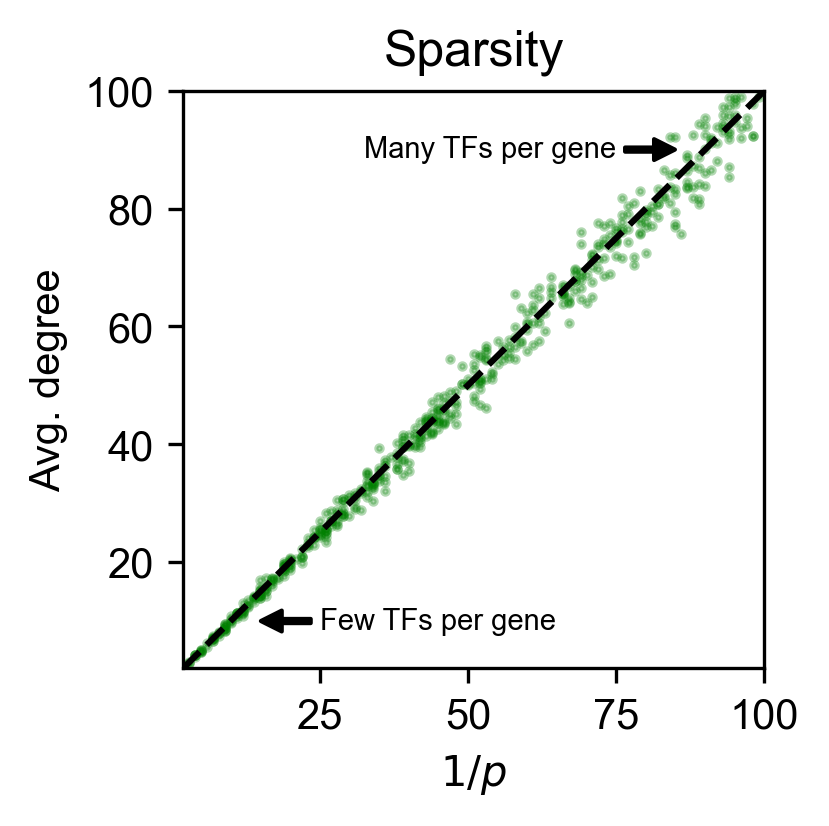

In [4]:
# Sparsity
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=300);

ax.plot(p, modE/n, 'g.', ms=3, alpha=0.3)
ax.plot([pmin, pmax], [pmin, pmax], 'k--')
ax.set_xlim(pmin,pmax); 
ax.set_ylim(pmin,pmax);
ax.set_xlabel(r'$1/p$'); 
ax.set_ylabel('Avg. degree');
ax.set_title('Sparsity');#: '+r'$p$');
ax.annotate('Few TFs per gene', xy=(15, 10), xytext=(25, 10), 
            fontsize=7, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );
ax.annotate('Many TFs per gene', xy=(85, 90), xytext=(75, 90), 
            fontsize=7, ha='right', va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

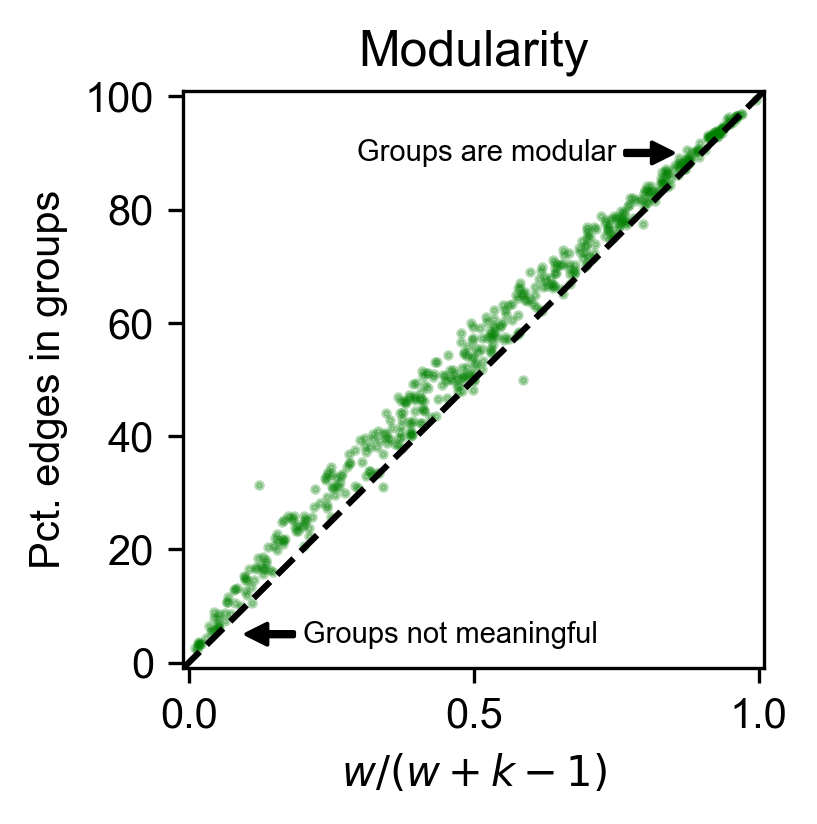

In [5]:
# Modularity (Fract. edges within)
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=300);
ax.plot((w/(w+k-1))[k>1], 100*np.array(stats['in_frac'])[k>1], 'g.', ms=3, alpha=0.3)
ax.plot([-0.01,1.01],[-1,101],'k--')

ax.set_xlim(-0.01,1.01);
ax.set_ylim(-1, 101); 
ax.set_ylabel('Pct. edges in groups');
ax.set_xlabel(r'$w/(w+k-1)$'); 
ax.set_title('Modularity');# groups: '+r'$w,k$');
ax.annotate('Groups not meaningful', xy=(.1, 5), xytext=(.2, 5), 
            fontsize=7, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );
ax.annotate('Groups are modular', xy=(.85, 90), xytext=(.75, 90), 
            fontsize=7, ha='right', va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

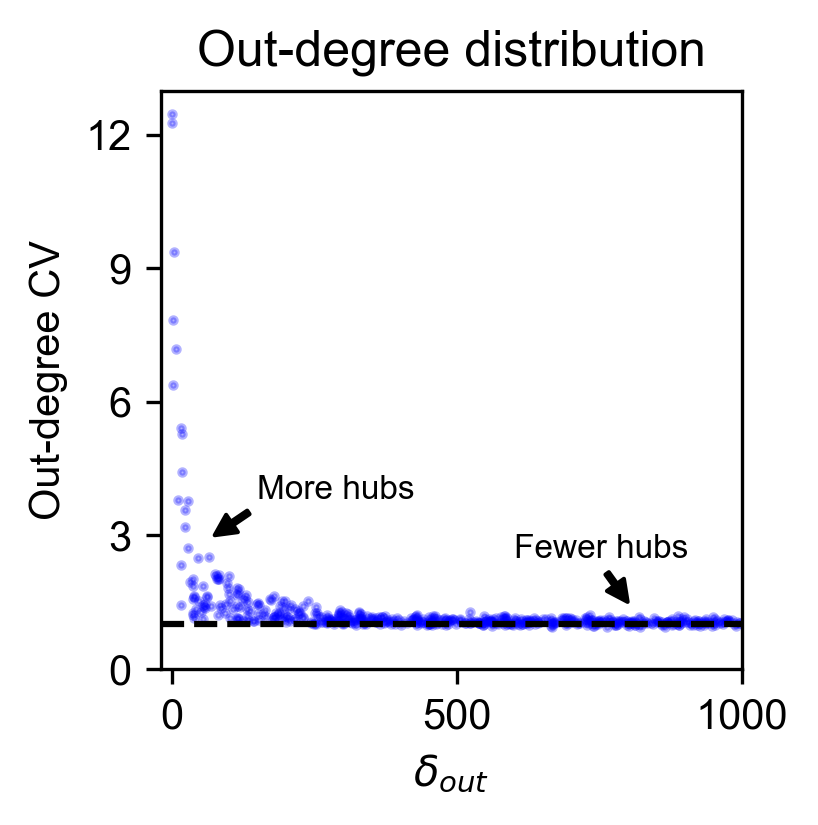

In [6]:
# Degree distribution (out)
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=300);
ax.plot(delta_out, n*np.sqrt(varo)/modE, 'b.', ms=3, alpha=0.3)
ax.plot([omin-20,omax],[1,1],'k--',linewidth=1.5)

ax.set_xlim(omin-20,omax); 
ax.set_ylim(0,max(maxi,maxo)+0.5)
ax.set_xlabel(r'$\delta_{out}$'); 
ax.set_ylabel('Out-degree CV');
ax.set_yticks(np.arange(0, 14, 3));
ax.set_title('Out-degree distribution');# '+r'$\delta_{out}$');
ax.annotate('More hubs', xy=(75, 3), xytext=(150, 4), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax.annotate('Fewer hubs', xy=(800, 1.5), xytext=(600, 2.5), 
            fontsize=8, ha='left',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

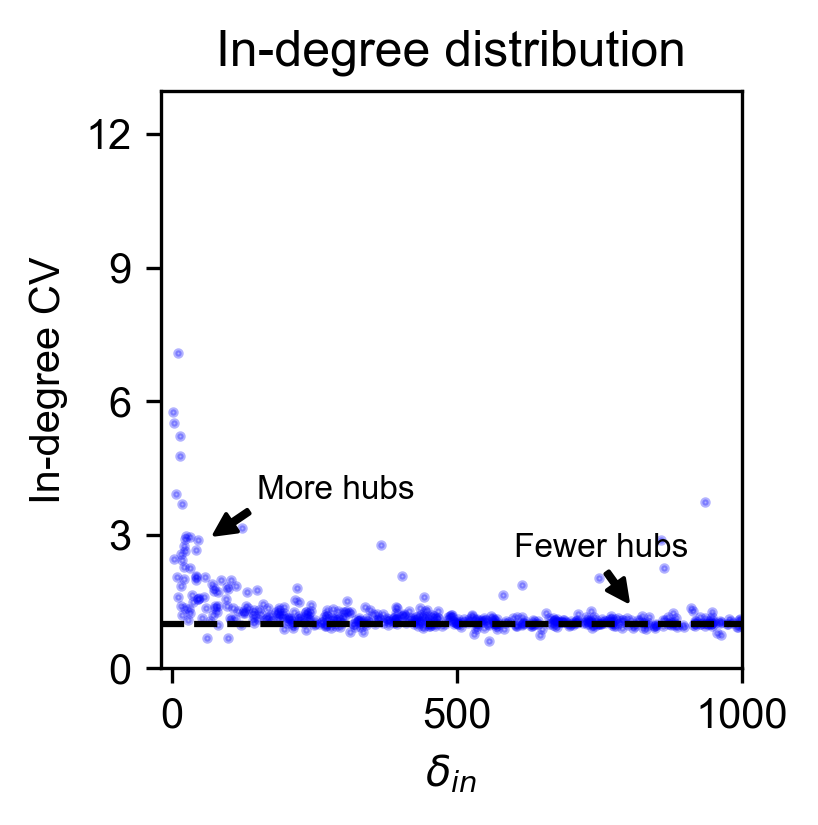

In [7]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=300);
ax.plot(delta_in, n*np.sqrt(vari)/modE, 'b.', ms=3, alpha=0.3)
ax.plot([imin-20,imax],[1,1],'k--',linewidth=1.5)

ax.set_xlabel(r'$\delta_{in}$'); 
ax.set_ylabel('In-degree CV');
ax.set_yticks(np.arange(0, 14, 3));
ax.set_xlim(imin-20,imax); 
ax.set_ylim(0,max(maxi,maxo)+0.5)
ax.set_title('In-degree distribution');# '+r'$\delta_{in}$');

ax.annotate('More hubs', xy=(75, 3), xytext=(150, 4), 
            fontsize=8, va='center',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );

ax.annotate('Fewer hubs', xy=(800, 1.5), xytext=(600, 2.5), 
            fontsize=8, ha='left',
            arrowprops=dict(facecolor='black', width=1, headlength=5, headwidth=5, shrink=0.01),
            );